# Ablation Study Analysis

This notebook generates horizontal bar charts comparing ablations against a baseline:
- Success Rate Change (%)
- Break Rate Change (%)
- Error bars showing standard deviation across seeds
- LaTeX table for ablation results

In [7]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import shared utilities
from analysis_utils import (
    # Constants
    ENTITY, PROJECT,
    TAG_EVAL_PERFORMANCE,
    METRIC_SUCCESS, METRIC_BREAKS, METRIC_TOTAL,
    FONT_TITLE, FONT_AXIS_LABEL, FONT_TICK,
    DEFAULT_DPI,
    # Data functions
    get_best_checkpoint_per_run,
    download_eval_performance_data,
    filter_top_n_runs,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Base method (full method that ablations are compared against)
BASE_CONFIG = {
    "key": "full",
    "display_name": "Full Method",
    #"tag": "LCLoP_perf-comp:2026-01-05_10:54",
    "tag": "MATCH_breakable_10N:2026-02-04_17:49",
}

# Ablations - list of configurations to compare against base
ABLATIONS = [
    #{"key": "no_zCon", "display_name": "No Z-Contact Reward", "tag": "ablate_no-z-contact:2026-01-05_10:54"},
    #{"key": "no_ssl", "display_name": "No Supervised Selection Loss", "tag": "ablate_no-SSL:2026-01-05_10:54"},
    #{"key": "ff", "display_name": "Perfect Selection", "tag": "ablate_ff:2026-01-05_10:54"},
    #{"key": "bias_25", "display_name": "Bias 25% Force", "tag": "ablate_bias-25:2026-01-05_10:54"},
    #{"key": "bias_50", "display_name": "No Bias", "tag": "ablate_bias-50:2026-01-05_10:54"},
    #{"key": "bias_75", "display_name": "Bias 75% Force", "tag": "ablate_bias-75:2026-01-05_10:54"},
    #{"key": "bias_93", "display_name": "Bias 93% Force", "tag": "ablate_bias-93:2026-01-05_10:54"},

    # no zcon + unbreakable
    #{"key": "no_ssl", "display_name": "No Supervised Selection Loss", "tag": "ablate_no-SSL:2026-02-02_13:42"},
    #{"key": "ff", "display_name": "Perfect Selection", "tag": "ablate_ff:2026-02-02_13:42"},
    #{"key": "bias_25", "display_name": "Bias 25% Force", "tag": "ablate_bias-25:2026-02-02_13:43"},
    #{"key": "bias_50", "display_name": "Bias 50% (No Bias)", "tag": "ablate_bias-50:2026-02-02_13:42"},
    #{"key": "bias_75", "display_name": "Bias 75% Force", "tag": "ablate_bias-75:2026-02-02_13:43"},
    #{"key": "bias_93", "display_name": "Bias 93% Force", "tag": "ablate_bias-93:2026-02-02_13:42"},

    # no zcon + 10N break force
    {"key": "no_ssl", "display_name": "No Supervised Selection Loss", "tag": "ablate_no-SSL_f10:2026-02-05_22:15"},
    {"key": "ff", "display_name": "Perfect Selection", "tag": "ablate_ff_f10:2026-02-05_22:14"},
    {"key": "bias_25", "display_name": "Bias 25% Force", "tag": "ablate_bias-25_f10:2026-02-05_22:16"},
    {"key": "bias_50", "display_name": "Bias 50% (No Bias)", "tag": "ablate_bias-50_f10:2026-02-05_22:14"},
    {"key": "bias_75", "display_name": "Bias 75% Force", "tag": "ablate_bias-75_f10:2026-02-05_22:16"},
    {"key": "bias_93", "display_name": "Bias 93% Force", "tag": "ablate_bias-93_f10:2026-02-05_22:15"},
]

# Policy Selection
TOP_N_POLICIES = None
MAX_CHECKPOINT = None  # Set to int to limit checkpoint search (e.g., 2000000 for first 2M steps)

# Bar Colors (one per configuration: base + ablations)
BAR_COLORS = [
    "#1f77b4",  # Blue (base)
    "#aec7e8",  # Light blue
    "#ffbb78",  # Light orange
    "#98df8a",  # Light green
    "#ff9896",  # Light red
    "#c5b0d5",  # Light purple
    "#c49c94",  # Light brown
    "#f7b6d2",  # Light pink
]

# Plot Configuration
FIGSIZE = (8, 5)
BAR_HEIGHT = 0.6
ERROR_BAR_CAPSIZE = 3
ERROR_BAR_LINEWIDTH = 1.5

In [8]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

api = wandb.Api()
best_checkpoints = {}  # best_checkpoints[key]

# Base method
print(f"\n{'='*60}")
print(f"Base: {BASE_CONFIG['display_name']} ({BASE_CONFIG['tag']})")
print(f"{'='*60}")
best_checkpoints[BASE_CONFIG["key"]] = get_best_checkpoint_per_run(
    api, BASE_CONFIG["tag"], max_checkpoint=MAX_CHECKPOINT
)

# Ablations
for ablation in ABLATIONS:
    print(f"\n{'='*60}")
    print(f"Ablation: {ablation['display_name']} ({ablation['tag']})")
    print(f"{'='*60}")
    best_checkpoints[ablation["key"]] = get_best_checkpoint_per_run(
        api, ablation["tag"], max_checkpoint=MAX_CHECKPOINT
    )


Base: Full Method (MATCH_breakable_10N:2026-02-04_17:49)
  Eval_performance_MATCH_breakable_f(10)_0: best checkpoint at step 1075200 (score: 95)
  Eval_performance_MATCH_breakable_f(10)_1: best checkpoint at step 1651200 (score: 97)
  Eval_performance_MATCH_breakable_f(10)_2: best checkpoint at step 2265600 (score: 97)
  Eval_performance_MATCH_breakable_f(10)_3: best checkpoint at step 1497600 (score: 82)
  Eval_performance_MATCH_breakable_f(10)_4: best checkpoint at step 2073600 (score: 94)

Ablation: No Supervised Selection Loss (ablate_no-SSL_f10:2026-02-05_22:15)
  Eval_performance_ablate_no-SSL_f(10)_0: best checkpoint at step 2572800 (score: 91)
  Eval_performance_ablate_no-SSL_f(10)_1: best checkpoint at step 1612800 (score: 89)
  Eval_performance_ablate_no-SSL_f(10)_2: best checkpoint at step 1536000 (score: 92)
  Eval_performance_ablate_no-SSL_f(10)_4: best checkpoint at step 1459200 (score: 67)
  Eval_performance_ablate_no-SSL_f(10)_3: best checkpoint at step 2457600 (score:

In [9]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

# Extra metrics for table (same as noise_robustness_analysis)
EXTRA_PERF_METRICS = ["avg_steps_to_success", "avg_force_in_contact"]

perf_data = {}  # perf_data[key]

# Base method
print(f"\nDownloading data for Base: {BASE_CONFIG['display_name']}...")
perf_data[BASE_CONFIG["key"]] = download_eval_performance_data(
    api, BASE_CONFIG["tag"], best_checkpoints[BASE_CONFIG["key"]],
    extra_metrics=EXTRA_PERF_METRICS
)

# Ablations
for ablation in ABLATIONS:
    print(f"Downloading data for Ablation: {ablation['display_name']}...")
    perf_data[ablation["key"]] = download_eval_performance_data(
        api, ablation["tag"], best_checkpoints[ablation["key"]],
        extra_metrics=EXTRA_PERF_METRICS
    )

# Compute statistics for each configuration
def compute_config_stats(df, best_ckpts, top_n):
    """Compute success/break/time/force rate statistics for a configuration."""
    if df.empty:
        return {
            "success_mean": 0, "success_std": 0, 
            "break_mean": 0, "break_std": 0, 
            "time_mean": np.nan, "time_std": np.nan,
            "force_mean": np.nan, "force_std": np.nan,
            "n_runs": 0, "n_runs_success": 0
        }
    
    if top_n is not None:
        df = filter_top_n_runs(df, best_ckpts, top_n, match_by="run_id")
    
    df = df.copy()
    df["success_rate"] = 100 * df["success"] / df["total"]
    df["break_rate"] = 100 * df["breaks"] / df["total"]
    df["time"] = df["avg_steps_to_success"] / 15.0  # Convert to seconds
    df["force"] = df["avg_force_in_contact"]
    
    # For time and force, only include runs with success > 0
    df_with_success = df[df["success_rate"] > 0]
    n_runs_success = len(df_with_success)
    
    return {
        "success_mean": df["success_rate"].mean(),
        "success_std": df["success_rate"].std(),
        "break_mean": df["break_rate"].mean(),
        "break_std": df["break_rate"].std(),
        "time_mean": df_with_success["time"].mean() if n_runs_success > 0 else np.nan,
        "time_std": df_with_success["time"].std() if n_runs_success > 0 else np.nan,
        "force_mean": df_with_success["force"].mean() if n_runs_success > 0 else np.nan,
        "force_std": df_with_success["force"].std() if n_runs_success > 0 else np.nan,
        "n_runs": len(df),
        "n_runs_success": n_runs_success
    }

stats = {}
all_configs = [BASE_CONFIG] + ABLATIONS
for config in all_configs:
    stats[config["key"]] = compute_config_stats(
        perf_data[config["key"]], 
        best_checkpoints[config["key"]], 
        TOP_N_POLICIES
    )

# Print summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
print(f"\nBase - {BASE_CONFIG['display_name']}:")
s = stats[BASE_CONFIG["key"]]
print(f"  Runs: {s['n_runs']}")
print(f"  Success: {s['success_mean']:.1f}% +/- {s['success_std']:.1f}%")
print(f"  Break: {s['break_mean']:.1f}% +/- {s['break_std']:.1f}%")
print(f"  Time: {s['time_mean']:.1f}s +/- {s['time_std']:.1f}s")
print(f"  Force: {s['force_mean']:.1f}N +/- {s['force_std']:.1f}N")

for ablation in ABLATIONS:
    s = stats[ablation["key"]]
    print(f"\n{ablation['display_name']}:")
    print(f"  Runs: {s['n_runs']}")
    print(f"  Success: {s['success_mean']:.1f}% +/- {s['success_std']:.1f}%")
    print(f"  Break: {s['break_mean']:.1f}% +/- {s['break_std']:.1f}%")
    if not np.isnan(s['time_mean']):
        print(f"  Time: {s['time_mean']:.1f}s +/- {s['time_std']:.1f}s")
        print(f"  Force: {s['force_mean']:.1f}N +/- {s['force_std']:.1f}N")
    else:
        print(f"  Time: N/A (no successful runs)")
        print(f"  Force: N/A (no successful runs)")



DATA SUMMARY

Base - Full Method:
  Runs: 5
  Success: 94.2% +/- 4.1%
  Break: 1.2% +/- 2.2%
  Time: 3.0s +/- 0.5s
  Force: 2.3N +/- 0.3N

No Supervised Selection Loss:
  Runs: 5
  Success: 89.2% +/- 7.7%
  Break: 2.8% +/- 3.7%
  Time: 3.4s +/- 0.6s
  Force: 1.9N +/- 0.3N

Perfect Selection:
  Runs: 5
  Success: 93.8% +/- 3.8%
  Break: 1.2% +/- 1.3%
  Time: 3.3s +/- 0.6s
  Force: 2.1N +/- 0.3N

Bias 25% Force:
  Runs: 5
  Success: 70.6% +/- 39.9%
  Break: 5.6% +/- 9.3%
  Time: 2.8s +/- 0.5s
  Force: 2.3N +/- 0.3N

Bias 50% (No Bias):
  Runs: 5
  Success: 92.0% +/- 2.7%
  Break: 1.8% +/- 2.9%
  Time: 2.9s +/- 0.4s
  Force: 2.1N +/- 0.2N

Bias 75% Force:
  Runs: 5
  Success: 86.2% +/- 16.9%
  Break: 2.4% +/- 3.7%
  Time: 3.4s +/- 0.9s
  Force: 2.1N +/- 0.3N

Bias 93% Force:
  Runs: 5
  Success: 60.0% +/- 45.3%
  Break: 1.0% +/- 0.7%
  Time: 4.6s +/- 2.3s
  Force: 1.9N +/- 0.1N


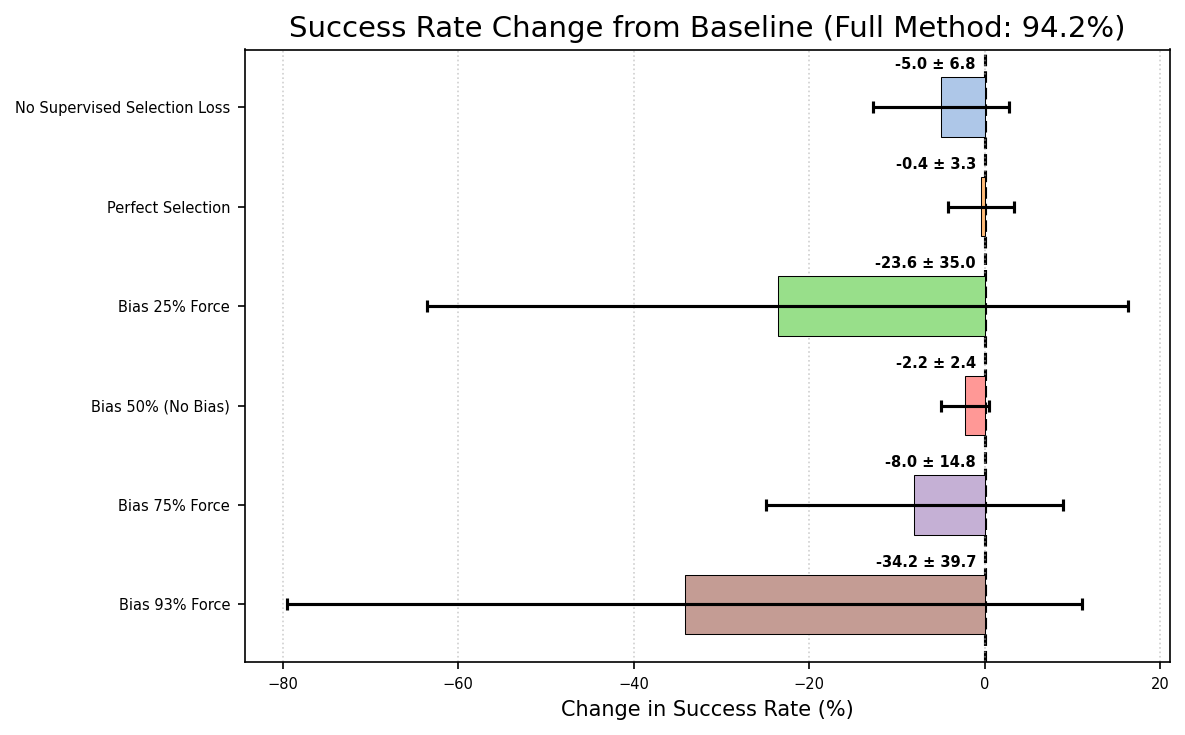

In [10]:
# ============================================================
# BLOCK 4: SUCCESS RATE ABLATION PLOT
# ============================================================

# Get baseline success rate
base_success = stats[BASE_CONFIG["key"]]["success_mean"]

# Compute percentage change from baseline for each ablation (exclude base)
display_names = []
changes = []
errors = []
colors = []
n_runs_list = []

for i, ablation in enumerate(ABLATIONS):
    s = stats[ablation["key"]]
    change = s["success_mean"] - base_success
    
    display_names.append(ablation["display_name"])
    changes.append(change)
    errors.append(s["success_std"])
    colors.append(BAR_COLORS[(i + 1) % len(BAR_COLORS)])
    n_runs_list.append(s["n_runs"])

# Reverse order so first ablation is at top
display_names = display_names[::-1]
changes = changes[::-1]
errors = errors[::-1]
colors = colors[::-1]
n_runs_list = n_runs_list[::-1]

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DEFAULT_DPI)
y_pos = np.arange(len(display_names))

# Draw horizontal bars
bars = ax.barh(y_pos, changes, height=BAR_HEIGHT, color=colors, edgecolor='black', linewidth=0.5)

# Add error bars
ax.errorbar(changes, y_pos, xerr=errors, fmt='none', 
            color='black', capsize=ERROR_BAR_CAPSIZE, 
            linewidth=ERROR_BAR_LINEWIDTH, capthick=ERROR_BAR_LINEWIDTH)

# Add mean ± 95% CI labels above each bar, right-aligned just left of the 0% line
for i in range(len(changes)):
    n = n_runs_list[i]
    sem = errors[i] / np.sqrt(n) if n > 0 else 0
    ci = 1.96 * sem
    label = f"{changes[i]:+.1f} \u00b1 {ci:.1f}"
    ax.text(-1, y_pos[i] + BAR_HEIGHT / 2 + 0.05, label,
            ha="right", va="bottom", fontsize=FONT_TICK, fontweight="bold")

# Add vertical line at 0 (baseline)
ax.axvline(x=0, color='black', linewidth=1.5, linestyle='--', zorder=0)

# Configure axes
ax.set_yticks(y_pos)
ax.set_yticklabels(display_names, fontsize=FONT_TICK)
ax.set_xlabel("Change in Success Rate (%)", fontsize=FONT_AXIS_LABEL)
ax.set_title(f"Success Rate Change from Baseline ({BASE_CONFIG['display_name']}: {base_success:.1f}%)", fontsize=FONT_TITLE)
ax.tick_params(axis='x', labelsize=FONT_TICK)
ax.xaxis.grid(True, linestyle=':', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

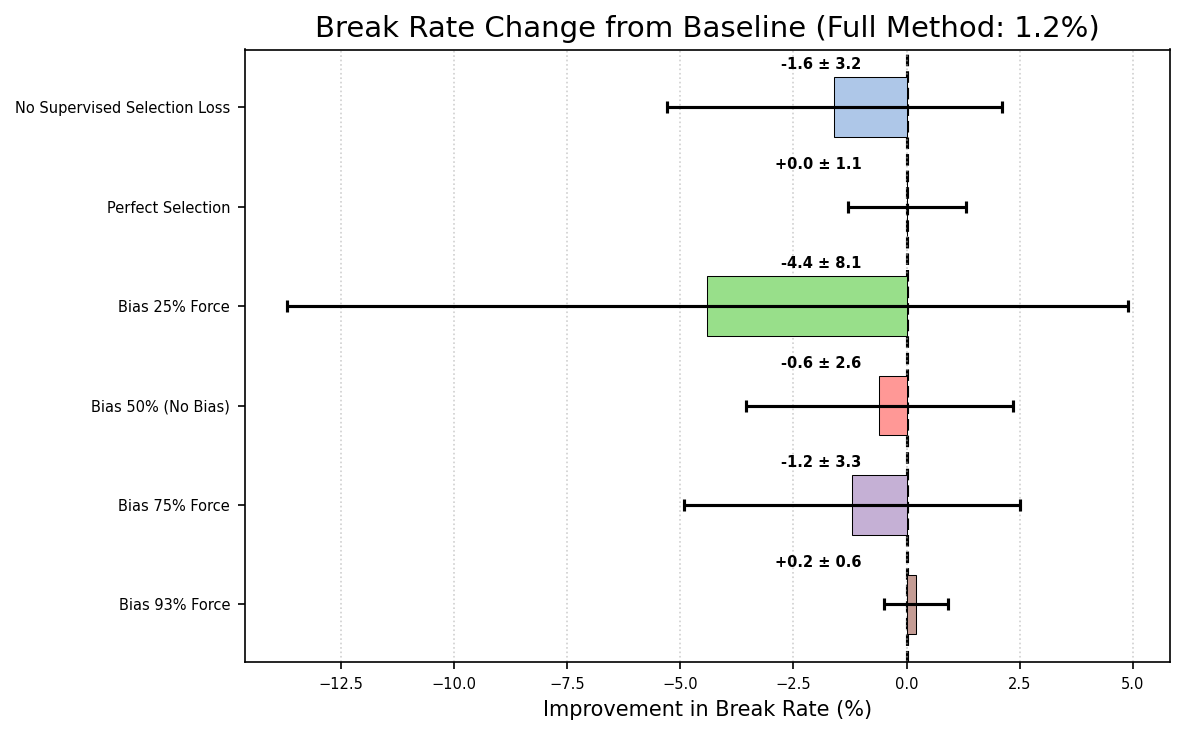

In [11]:
# ============================================================
# BLOCK 5: BREAK RATE ABLATION PLOT
# ============================================================

# Break rate direction: if True, lower break rate = positive change (improvement)
LOWER_IS_BETTER = True

# Get baseline break rate
base_break = stats[BASE_CONFIG["key"]]["break_mean"]

# Compute percentage change from baseline for each ablation (exclude base)
display_names = []
changes = []
errors = []
colors = []
n_runs_list = []

for i, ablation in enumerate(ABLATIONS):
    s = stats[ablation["key"]]
    
    if LOWER_IS_BETTER:
        change = base_break - s["break_mean"]  # Lower = positive (improvement)
    else:
        change = s["break_mean"] - base_break  # Raw direction
    
    display_names.append(ablation["display_name"])
    changes.append(change)
    errors.append(s["break_std"])
    colors.append(BAR_COLORS[(i + 1) % len(BAR_COLORS)])
    n_runs_list.append(s["n_runs"])

# Reverse order so first ablation is at top
display_names = display_names[::-1]
changes = changes[::-1]
errors = errors[::-1]
colors = colors[::-1]
n_runs_list = n_runs_list[::-1]

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DEFAULT_DPI)
y_pos = np.arange(len(display_names))

# Draw horizontal bars
bars = ax.barh(y_pos, changes, height=BAR_HEIGHT, color=colors, edgecolor='black', linewidth=0.5)

# Add error bars
ax.errorbar(changes, y_pos, xerr=errors, fmt='none', 
            color='black', capsize=ERROR_BAR_CAPSIZE, 
            linewidth=ERROR_BAR_LINEWIDTH, capthick=ERROR_BAR_LINEWIDTH)

# Add mean ± 95% CI labels above each bar, right-aligned just left of the 0% line
for i in range(len(changes)):
    n = n_runs_list[i]
    sem = errors[i] / np.sqrt(n) if n > 0 else 0
    ci = 1.96 * sem
    label = f"{changes[i]:+.1f} \u00b1 {ci:.1f}"
    ax.text(-1, y_pos[i] + BAR_HEIGHT / 2 + 0.05, label,
            ha="right", va="bottom", fontsize=FONT_TICK, fontweight="bold")

# Add vertical line at 0 (baseline)
ax.axvline(x=0, color='black', linewidth=1.5, linestyle='--', zorder=0)

# Configure axes
ax.set_yticks(y_pos)
ax.set_yticklabels(display_names, fontsize=FONT_TICK)
x_label = "Improvement in Break Rate (%)" if LOWER_IS_BETTER else "Change in Break Rate (%)"
ax.set_xlabel(x_label, fontsize=FONT_AXIS_LABEL)
ax.set_title(f"Break Rate Change from Baseline ({BASE_CONFIG['display_name']}: {base_break:.1f}%)", fontsize=FONT_TITLE)
ax.tick_params(axis='x', labelsize=FONT_TICK)
ax.xaxis.grid(True, linestyle=':', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [12]:
# ============================================================
# BLOCK 6: LATEX TABLE - ABLATION RESULTS
# ============================================================

# Display Options
SHOW_READABLE_PREVIEW = True  # Set to False to skip the readable table preview
INCLUDE_BREAK_RATE = False  # Set to False to remove the Break column from the table

# Table Configuration
TABLE_CAPTION = "Ablation study results."
TABLE_LABEL = "tab:ablation"
DECIMAL_PLACES = 1

# Metrics: (display_name, stat_key_mean, stat_key_std, higher_is_better)
TABLE_METRICS = [
    ("Success", "success_mean", "success_std", True),
    ("Break", "break_mean", "break_std", False),
    ("Time (s)", "time_mean", "time_std", False),
    ("Force (N)", "force_mean", "force_std", False),
]

# Filter out Break column if not included
if not INCLUDE_BREAK_RATE:
    TABLE_METRICS = [m for m in TABLE_METRICS if m[0] != "Break"]

def format_mean_std(mean, std, decimal=1):
    if np.isnan(mean):
        return "N/A"
    return f"{mean:.{decimal}f} $\\pm$ {std:.{decimal}f}"

def format_mean_std_plain(mean, std, decimal=1):
    if np.isnan(mean):
        return "N/A"
    return f"{mean:.{decimal}f} +/- {std:.{decimal}f}"

# ---- READABLE TABLE PREVIEW ----
if SHOW_READABLE_PREVIEW:
    print("=" * 100)
    print("TABLE VALUES PREVIEW")
    print("=" * 100)

    # Build header
    header_labels = ["Configuration"] + [f"{m} {'(+)' if h else '(-)'}" for m, _, _, h in TABLE_METRICS]
    col_widths = [max(30, len(h) + 2) for h in header_labels]
    col_widths[0] = 32  # Configuration column wider

    header_line = "".join(h.ljust(w) for h, w in zip(header_labels, col_widths))
    print(header_line)
    print("-" * len(header_line))

    # Build data rows (ablations only)
    for config in ABLATIONS:
        s = stats[config["key"]]
        row_cells = [config["display_name"]]
        for display_name, mean_key, std_key, _ in TABLE_METRICS:
            value_str = format_mean_std_plain(s[mean_key], s[std_key], DECIMAL_PLACES)
            row_cells.append(value_str)
        row_line = "".join(c.ljust(w) for c, w in zip(row_cells, col_widths))
        print(row_line)

    print("-" * len(header_line))
    print()

# ---- LATEX TABLE ----
UP_ARROW = "$\\uparrow$"
DOWN_ARROW = "$\\downarrow$"
header_parts = [f"{m} {UP_ARROW if h else DOWN_ARROW}" for m, _, _, h in TABLE_METRICS]
header_row = "Configuration & " + " & ".join(header_parts) + " \\\\"

latex_lines = [
    "\\begin{table}[t]",
    "\\centering",
    f"\\caption{{{TABLE_CAPTION}}}",
    f"\\label{{{TABLE_LABEL}}}",
    "\\begin{tabular}{l" + "c" * len(TABLE_METRICS) + "}",
    "\\toprule",
    header_row,
    "\\midrule",
]

# Only include ablations (not base/full method)
for config in ABLATIONS:
    s = stats[config["key"]]
    
    cells = [config["display_name"]]
    for display_name, mean_key, std_key, _ in TABLE_METRICS:
        value_str = format_mean_std(s[mean_key], s[std_key], DECIMAL_PLACES)
        cells.append(value_str)
    
    latex_lines.append(" & ".join(cells) + " \\\\")

latex_lines.extend([
    "\\bottomrule",
    "\\end{tabular}",
    "\\end{table}",
])

latex_output = "\n".join(latex_lines)
print(latex_output)

TABLE VALUES PREVIEW
Configuration                   Success (+)                   Time (s) (-)                  Force (N) (-)                 
--------------------------------------------------------------------------------------------------------------------------
No Supervised Selection Loss    89.2 +/- 7.7                  3.4 +/- 0.6                   1.9 +/- 0.3                   
Perfect Selection               93.8 +/- 3.8                  3.3 +/- 0.6                   2.1 +/- 0.3                   
Bias 25% Force                  70.6 +/- 39.9                 2.8 +/- 0.5                   2.3 +/- 0.3                   
Bias 50% (No Bias)              92.0 +/- 2.7                  2.9 +/- 0.4                   2.1 +/- 0.2                   
Bias 75% Force                  86.2 +/- 16.9                 3.4 +/- 0.9                   2.1 +/- 0.3                   
Bias 93% Force                  60.0 +/- 45.3                 4.6 +/- 2.3                   1.9 +/- 0.1               